#Tugas Akhir DL: Neural Style Transfer


*   Fatha Marvin Yudhakusuma
*   Muhammad Mahdi
*   Alleludo Panji Dewa Atmaja
*   Bagus Arif Arikusworo



In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

###Import Libraries

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip -O coco_train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip -O coco_val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip

###Download Dataset

In [ ]:
from zipfile import ZipFile, BadZipFile
import os
def extract_zip_file(extract_path):
    try:
        with ZipFile(extract_path+".zip") as zfile:
            zfile.extractall(extract_path)
        # remove zipfile
        zfileTOremove=f"{extract_path}"+".zip"
        if os.path.isfile(zfileTOremove):
            os.remove(zfileTOremove)
        else:
            print("Error: %s file not found" % zfileTOremove)
    except BadZipFile as e:
        print("Error:", e)
extract_train_path = "./coco_train2017"
extract_val_path = "./coco_val2017"
extract_ann_path="./coco_ann2017"
extract_zip_file(extract_train_path)
extract_zip_file(extract_val_path)
extract_zip_file(extract_ann_path)

#####Train Image Example

In [ ]:
from IPython.display import Image, display

image_path = "./coco_train2017/train2017/000000000009.jpg"  # Replace with the actual path to the image you want to display
display(Image(filename=image_path))

#####Validation Image Example

In [ ]:
image_path = "./coco_val2017/val2017/000000000139.jpg"  # Replace with the actual path to the image you want to display
display(Image(filename=image_path))

### Membuat Pengurai Data
Kumpulan data COCO menyimpan anotasi dalam file JSON. Untuk mengurai file-file ini, kita perlu memuatnya ke dalam memori dan mengekstrak informasi yang relevan.

In [ ]:
from collections import defaultdict
import json
import numpy as np
class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, 'r') as f:
            coco = json.load(f)

        self.annIm_dict = defaultdict(list)
        self.cat_dict = {}
        self.annId_dict = {}
        self.im_dict = {}
        self.licenses_dict = {}
        for ann in coco['annotations']:
            self.annIm_dict[ann['image_id']].append(ann)
            self.annId_dict[ann['id']]=ann
        for img in coco['images']:
            self.im_dict[img['id']] = img
        for cat in coco['categories']:
            self.cat_dict[cat['id']] = cat
        for license in coco['licenses']:
            self.licenses_dict[license['id']] = license
    def get_imgIds(self):
        return list(self.im_dict.keys())
    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]
    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]
    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]
    def get_imgLicenses(self,im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
        return [self.licenses_dict[lic_id] for lic_id in lic_ids]

### Visualisasikan Data

In [ ]:
coco_annotations_file="./coco_ann2017/annotations/instances_val2017.json"
coco_images_dir="./coco_val2017/val2017"
coco= COCOParser(coco_annotations_file, coco_images_dir)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# define a list of colors for drawing bounding boxes
color_list = ["pink", "red", "teal", "blue", "orange", "yellow", "black", "magenta","green","aqua"]*10
num_imgs_to_disp = 4
total_images = len(coco.get_imgIds()) # total number of images
sel_im_idxs = np.random.permutation(total_images)[:num_imgs_to_disp]
img_ids = coco.get_imgIds()
selected_img_ids = [img_ids[i] for i in sel_im_idxs]
ann_ids = coco.get_annIds(selected_img_ids)
im_licenses = coco.get_imgLicenses(selected_img_ids)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax = ax.ravel()
for i, im in enumerate(selected_img_ids):
    image = Image.open(f"{coco_images_dir}/{str(im).zfill(12)}.jpg")
    ann_ids = coco.get_annIds(im)
    annotations = coco.load_anns(ann_ids)
    for ann in annotations:
        bbox = ann['bbox']
        x, y, w, h = [int(b) for b in bbox]
        class_id = ann["category_id"]
        class_name = coco.load_cats(class_id)[0]["name"]
        license = coco.get_imgLicenses(im)[0]["name"]
        color_ = color_list[class_id]
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
        t_box=ax[i].text(x, y, class_name,  color='red', fontsize=10)
        t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
        ax[i].add_patch(rect)

    ax[i].axis('off')
    ax[i].imshow(image)
    ax[i].set_xlabel('Longitude')
    ax[i].set_title(f"License: {license}")
plt.tight_layout()
plt.show()

#Pre Processing

###Resize

In [ ]:
import os
import multiprocessing
import cv2
import shutil
from tqdm import tqdm

def resize_image(args):
    input_path, output_path, target_size = args
    try:
        img = cv2.imread(input_path)
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
        cv2.imwrite(output_path, img)
    except Exception as e:
        print(f"Error resizing {input_path}: {e}")

def resize_coco_dataset(input_dir, output_dir, target_size=(512, 512), max_workers=8):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    input_files = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                input_path = os.path.join(root, file)
                output_path = os.path.join(output_dir, file)
                input_files.append((input_path, output_path, target_size))

    with multiprocessing.Pool(max_workers) as pool:
        list(tqdm(pool.imap(resize_image, input_files), total=len(input_files), desc="Resizing"))

    # Delete the original input directory after successful resizing
    try:
        shutil.rmtree(input_dir)
    except Exception as e:
        print(f"Error deleting {input_dir}: {e}")

# Example usage:
input_train_dir = "./coco_train2017"
input_val_dir = "./coco_val2017"
output_train_dir = "./resized_coco_train2017"
output_val_dir = "./resized_coco_val2017"

resize_coco_dataset(input_train_dir, output_train_dir)
resize_coco_dataset(input_val_dir, output_val_dir)

In [ ]:
from IPython.display import Image

image_path = "/content/resized_coco_train2017/000000000009.jpg"  # Replace with the actual path to the image you want to display
Image(filename=image_path)

###Augmentation (masi error)


In [ ]:
import os
import random
import shutil
import multiprocessing
from tqdm import tqdm
import imgaug as ia
from imgaug import augmenters as iaa
import cv2

def augment_image(args):
    input_path, output_path, seq = args
    try:
        img = cv2.imread(input_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = seq.augment_image(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_path, img)
    except Exception as e:
        print(f"Error augmenting {input_path}: {e}")

def augment_coco_dataset(input_dir, output_dir, augmentation_ratio=0.1, max_workers=8):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    input_files = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                input_path = os.path.join(root, file)
                output_path = os.path.join(output_dir, file)
                input_files.append((input_path, output_path))

    num_augmented_files = int(len(input_files) * augmentation_ratio)
    input_files = random.sample(input_files, num_augmented_files)

    sometimes = lambda aug: iaa.Sometimes(0.85, aug)
    seq = iaa.Sequential(
        [
            iaa.SomeOf((0, 5),
                       [   iaa.Grayscale(alpha=(0.0, 1.0)),
                           iaa.Fliplr(0.5),
                           iaa.Flipud(0.5),
                           sometimes(iaa.Crop(percent=(0, 0.1))),
                           sometimes(iaa.Affine(
                               scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                               translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                               rotate=(-45, 45),
                               shear=(-16, 16),
                               order=[0, 1],
                               cval=(0, 255),
                               mode=ia.ALL
                           )),
                           ],
                         random_order=True
                         )
        ],
        random_order=True
    )

    input_files = input_files[:int(len(input_files) * augmentation_ratio)]
    with multiprocessing.Pool(max_workers) as pool:
        list(tqdm(pool.imap(augment_image, [(input_path, output_path, seq) for input_path, output_path in input_files]), total=len(input_files), desc="Augmenting"))

# Example usage:
input_train_dir = "./resized_coco_train2017"
input_val_dir = "./resized_coco_val2017"
output_train_dir = "./resized_and_augmented_coco_train2017"
output_val_dir = "./resized_and_augmented_coco_val2017"

augment_coco_dataset(input_train_dir, output_train_dir, augmentation_ratio=0.5)
augment_coco_dataset(input_val_dir, output_val_dir, augmentation_ratio=0.5)

In [ ]:
from IPython.display import Image

image_path = "/content/resized_and_augmented_coco_train2017/000000048384.jpg"  # Replace with the actual path to the image you want to display
Image(filename=image_path)

In [ ]:
import os

def rename_files(folder_path):
    files = os.listdir(folder_path)
    files.sort()
    count = 1
    for file_name in files:
        if os.path.isfile(os.path.join(folder_path, file_name)):
            new_name = f"aug_{count}.png"  # Change the extension to the appropriate one if needed
            os.rename(os.path.join(folder_path, file_name), os.path.join(folder_path, new_name))
            count += 1

# Provide the folder path
folder_path_train = "./resized_and_augmented_coco_train2017"
folder_path_val = "./resized_and_augmented_coco_val2017"

rename_files(folder_path_train)
rename_files(folder_path_val)

In [ ]:
import shutil
import os

def move_png_files_and_delete_folder(src_folder, dest_folder):
    # Ensure destination folder exists, create if not
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)

    # Get a list of all files in the source folder
    files = os.listdir(src_folder)

    # Filter PNG files
    png_files = [file for file in files if file.lower().endswith('.png')]

    # Move PNG files to the destination folder
    for png_file in png_files:
        src_path = os.path.join(src_folder, png_file)
        dest_path = os.path.join(dest_folder, png_file)
        shutil.move(src_path, dest_path)
        print(f"Moved {png_file} to {dest_folder}")

    # Delete original files in the source folder
    for png_file in png_files:
        file_path = os.path.join(src_folder, png_file)
        os.remove(file_path)
        print(f"Deleted {file_path}")

    # Delete the source folder
    shutil.rmtree(src_folder)
    print(f"Deleted folder: {src_folder}")

# Provide the source and destination folder paths
source_folder_train = "./resized_coco_train2017"
destination_folder_train = "./resized_and_augmented_coco_train2017"

source_folder_val = "./resized_coco_val2017"
destination_folder_val = "./resized_and_augmented_coco_val2017"

move_png_files_and_delete_folder(source_folder_train, destination_folder_train)
move_png_files_and_delete_folder(source_folder_val, destination_folder_val)

###Filter

# Model

### Model menggunakan Keras

Import Keras

In [20]:
from tensorflow.keras.models import Model as mo
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow import keras
import PIL.Image
import numpy as np

In [21]:
import tensorflow as tf

In [22]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Kita akan menggunakan CNN VGG19 untuk training CNN dengan include_top False agar Softmax layer akhir menjadi classifier 1000 class

In [23]:
from tensorflow.keras.applications import VGG19
model = VGG19(weights="imagenet", include_top=False)

Lalu, dibuatkan dictionary untuk semua kunci sebagai nama layer dan nilai sebagai layer output

In [24]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [25]:
print()
for layer in model.layers:
  print(layer.name)


input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Terakhir, model didefinisikan dengan input sesuai spesifikasi VGG19 dan output sesuai dictionary per layer

In [26]:
feature_extractor = mo(inputs=model.inputs, outputs=outputs_dict)

Selanjutnya adalah mendefinisikan konten dan style karakteristik

In [27]:
style_layers = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]

content_layers = "block5_conv2"

In [28]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

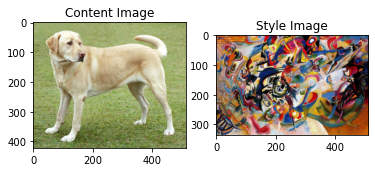

In [29]:
import tensorflow as tf
import matplotlib.pyplot as plt

# content_path = "/content/resized_coco_val2017/000000000776.jpg" "sesuaikan"
# style_path = "/content/resized_and_augmented_coco_val2017/aug_103.png" "atau ganti model style lain"
# style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')


content_path = "C://Users/mahdi/Downloads/YellowLabradorLooking_new.jpg"
style_path = "C://Users/mahdi/Downloads/Vassily_Kandinsky,_1913_-_Composition_7.jpg"

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

c_image = load_img(content_path)
s_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(c_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(s_image, 'Style Image')

plt.show()


In [30]:
# code ini jalan pas aku coba di input gambar lain , tpi karena gambar di sni blm bs blm ku run

def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [31]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(s_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5255
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8853
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.237
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.143
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2532
  mean:  59.179485



In [32]:
#mengubah definisi string menjadi sebuah daftar atau list

style_layers = ["block1_conv1", "block2_conv1", "block3_conv1", "block4_conv1", "block5_conv1"]
content_layers = ["block5_conv2"]

### Gram Matrix

Jadi untuk gaya komputasi biaya kita tidak boleh membandingkan aktivasi secara langsung. sebaliknya kita akan mendapatkan tensor baru yang berisi gaya aktivasi dan kita dapat melakukan penghitungan biaya yang serupa dengan biaya konten. Sehingga tensor baru tersebut tidak lain hanyalah matriks gram

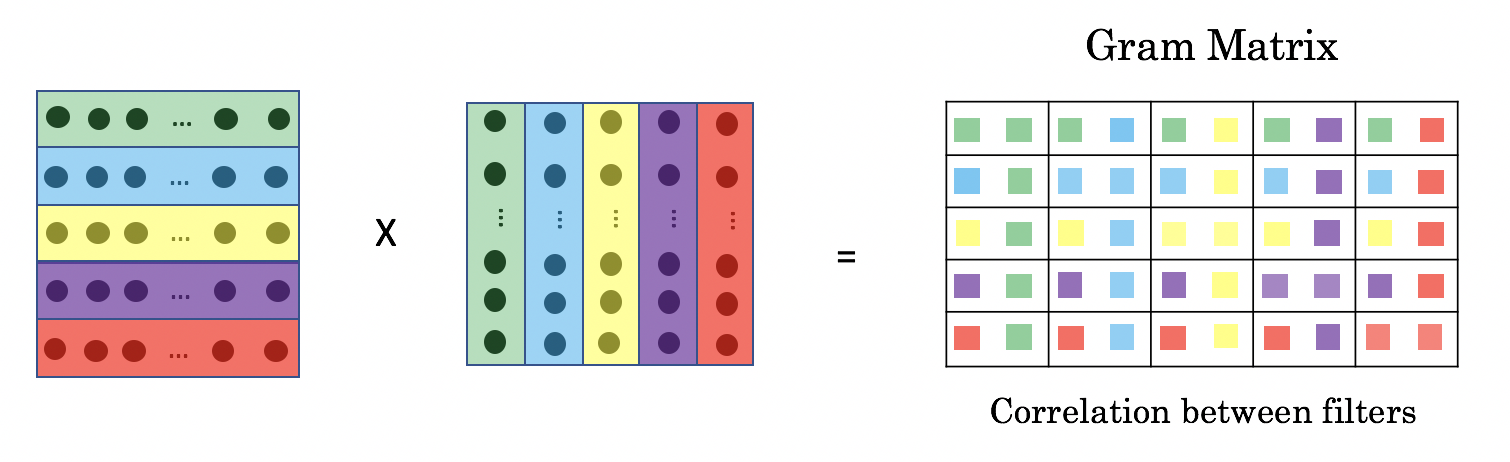

In [33]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Style Content Loss

In [34]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [35]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(c_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055228476
    max:  28014.559
    mean:  263.79022

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.49
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.9766

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320501.0
    mean:  134288.86

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.38
    mean:  1487.0381

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8782
    mean:  13.764152


In [36]:
style_targets = extractor(s_image)['style']
content_targets = extractor(c_image)['content']

image = tf.Variable(c_image)



In [37]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

### Optimizer

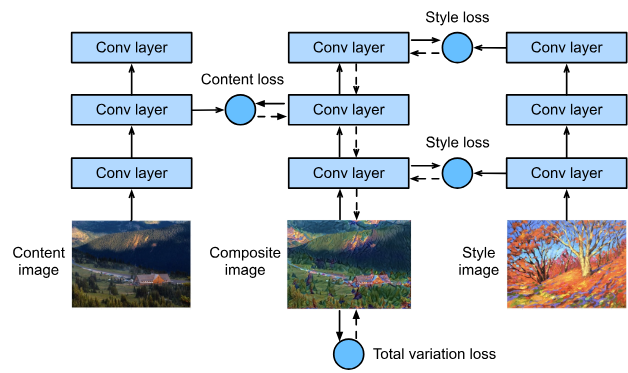

In [39]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [40]:
style_weight=1e-2
content_weight=1e4

### Total Cost

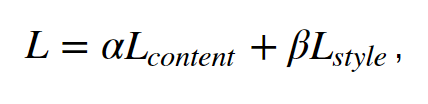

Loss gaya komputasi sedikit berbeda. Loss konten memberikan hasil matematis yang menunjukkan betapa miripnya kedua gambar ini. Semakin mirip berarti semakin menuju nol

Namun gaya komputasi memberikan hasil matematis yang menunjukkan betapa miripnya fitur atau gaya dibandingkan kontennya.

Itu sebabnya total loss memberikan kesalahan dengan menggunakan kedua loss tersebut. Loss konten menghitung untuk menentukan seberapa mirip gambar-gambar itu, apa pun warnanya, gaya Loss gaya menghitung untuk menentukan seberapa mirip gaya gambar satu sama lain daripada konten. Misalnya. Gaya font a dan b --> loss gaya huruf a dan b --> loss konten

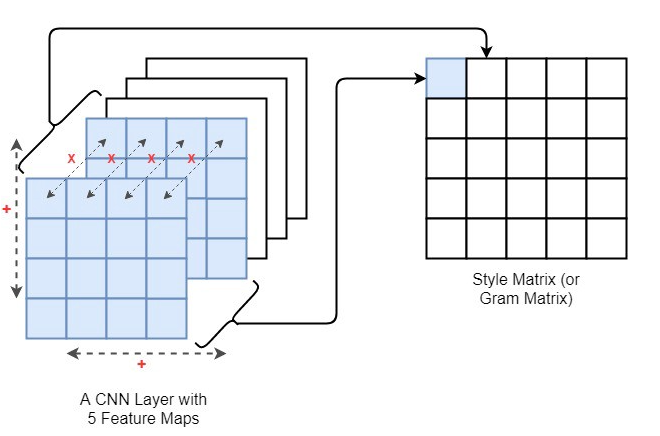

Disini Style loss menggunakan matrix gram. Matriks Gram mengukur distribusi fitur pada peta fitur dalam sebuah lapisan, meminimalkan hilangnya gaya dengan mempertahankan tingkat distribusi fitur yang sama pada gaya dan gambar yang dihasilkan.

Content Loss: CNN secara efisien menangkap konten yang diinginkan dalam gambar yang dihasilkan dengan berfokus pada informasi jaringan tingkat tinggi dan nilai piksel individual pada tingkat yang lebih rendah. Fungsi reduksi_sum menghitung jumlah elemen di seluruh parameter, membandingkan masukan dan gambar yang dihasilkan.

In [41]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [42]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

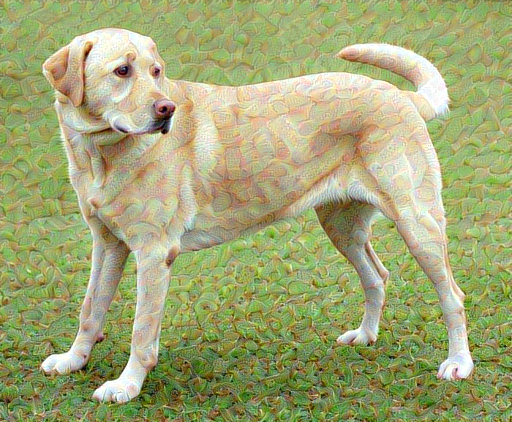

In [43]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [44]:
from IPython import display
import IPython
from IPython.display import clear_output

### Training

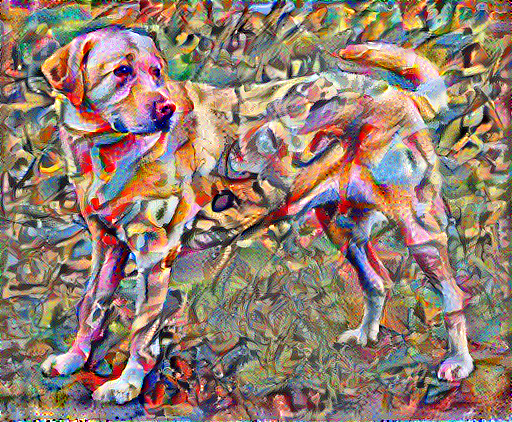

Train step: 1000
Total time: 856.6


In [45]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))